## **EDA Notebook**

**IMPORTANT:** run `setup_data.py`

In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import os


import cv2
import matplotlib.pyplot as plt
from PIL import Image


from src.visualizations import *
from src.preproc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
img_metadata_df = pd.read_csv('../image_metadata/image_data.csv')
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    3
Cancer Type            4
Magnification          4
dtype: int64

In [3]:
img_metadata_df.dropna(inplace=True)
img_metadata_df.head(3)

path_to_image Benign or Malignant  \
0  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
1  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
2  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   

  Cancer Type Magnification  
0    Adenosis          100X  
1    Adenosis          100X  
2    Adenosis          100X

In [4]:
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    0
Cancer Type            0
Magnification          0
dtype: int64

In [ ]:
def update_image_paths(metadata):
    
    def get_image_location(row):
        
        possible_locations = ['train', 'test', 'val']
        for location in possible_locations:
            full_path = os.path.join('..', 'data', row['Magnification'], location, row['image_name'])
            if os.path.exists(full_path):
                return location
            
        print(f"WARNING: {row['image_name']} not found in any folder.")
        return "NOT FOUND"
    
    metadata.dropna(inplace=True) # Remove missing values (4 rows only)
    
    # These are temporary columns to help us find the new paths of the images
    metadata['image_name'] = metadata['path_to_image'].apply(lambda x: os.path.basename(x))
    metadata['image_location'] = metadata.apply(get_image_location, axis=1)
    
    # Update the paths to our new structure of folders
    metadata['path_to_image'] = metadata.apply(
        lambda row: os.path.join('..', 'data', row['Magnification'], row['image_location'], row['image_name']),
        axis=1
    )
    
    metadata.drop(columns=['image_name', 'image_location'], inplace=True)
    return metadata

img_metadata_df = update_image_paths(img_metadata_df)

In [12]:
def get_image_location(row):
    possible_locations = ['train', 'test', 'val']
    for location in possible_locations:
        if location in row['path_to_image']:
            return location
    return "NOT FOUND"

img_metadata_df['image_location'] = img_metadata_df.apply(get_image_location, axis=1)
img_metadata_df.head(3)

path_to_image Benign or Malignant  \
0  ..\data\100X\train\SOB_B_A-14-22549AB-100-011.png              Benign   
1   ..\data\100X\test\SOB_B_A-14-22549AB-100-005.png              Benign   
2   ..\data\100X\test\SOB_B_A-14-22549AB-100-004.png              Benign   

  Cancer Type Magnification image_location  
0    Adenosis          100X          train  
1    Adenosis          100X           test  
2    Adenosis          100X           test

<i> The updated version of the image metadata csv files contains the actual image paths, and the missing images have been removed. </i>

In [7]:
grouped = img_metadata_df.groupby(
    ['Benign or Malignant', 'Cancer Type', 'Magnification']
).size().reset_index(name='Count')

pivot_table = grouped.pivot_table(
    index=['Benign or Malignant', 'Cancer Type'],
    columns='Magnification',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

magnification_order = ['40X', '100X', '200X', '400X']
pivot_table = pivot_table.reindex(columns=magnification_order, fill_value=0)

pivot_table['Total'] = pivot_table.sum(axis=1)

column_sub_totals_benign = pivot_table[:4].sum(axis=0)
column_sub_totals_malignant = pivot_table[4:8].sum(axis=0)
column_totals = pivot_table.sum(axis=0)

pivot_table.loc[('Sub Total', 'Benign'), :] = column_sub_totals_benign
pivot_table.loc[('Sub Total', 'Maligant'), :] = column_sub_totals_malignant
pivot_table.loc[('Total', ''), :] = column_totals

pivot_table = pivot_table.astype(int)
pivot_table

Magnification                             40X  100X  200X  400X  Total
Benign or Malignant Cancer Type                                       
Benign              Adenosis              114   113   111   106    444
                    Fibroadenoma          253   260   264   237   1014
                    Phyllodes Tumor       109   121   108   115    453
                    Tubular Adenoma       149   150   140   130    569
Malignant           Ductal Carcinoma      863   903   896   788   3450
                    Lobular Carcinoma     156   170   163   137    626
                    Mucinous Carcinoma    205   221   195   168    789
                    Papillary Carcinoma   145   142   135   138    560
Sub Total           Benign                625   644   623   588   2480
                    Maligant             1369  1436  1389  1231   5425
Total                                    1994  2080  2012  1819   7905

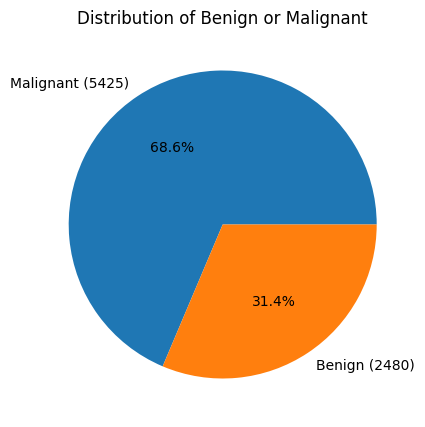

In [8]:
plot_distribution_pie(img_metadata_df, 'Benign or Malignant')

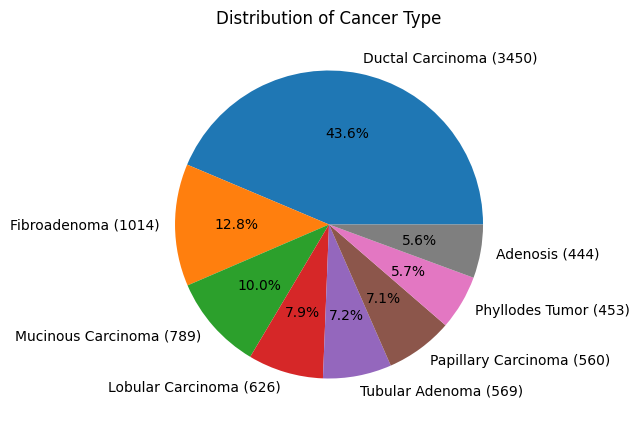

In [9]:
plot_distribution_pie(img_metadata_df, 'Cancer Type')

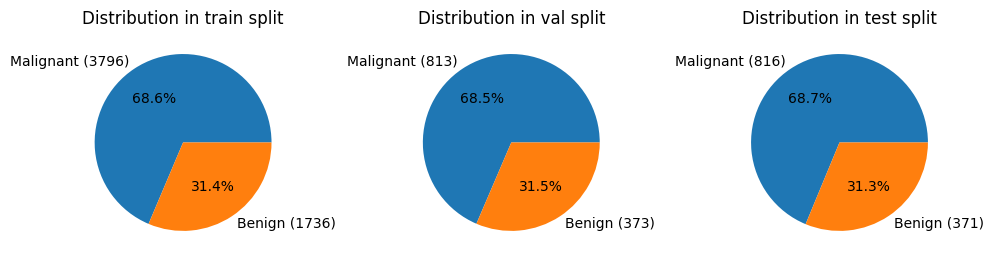

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

splits = ['train', 'val', 'test']
for ax, split in zip(axes, splits):
    plot_distribution_pie(img_metadata_df[img_metadata_df['image_location'] == split], 'Benign or Malignant', ax=ax)
    ax.set_title(f'Distribution in {split} split')

plt.tight_layout()
plt.show()

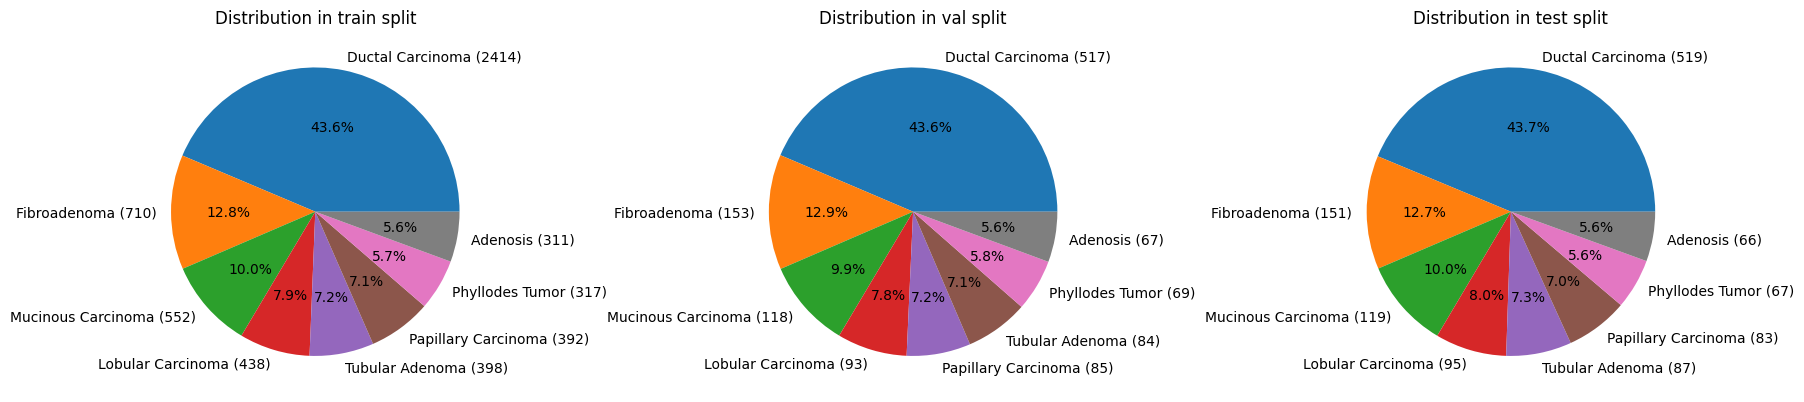

In [ ]:
def plot_distribution_pie(data, col, ax=None, figsize=(10, 5)):
    counts = data[col].value_counts()
    counts.plot(kind='pie', autopct='%1.1f%%', labels=[f'{label} ({count})' for label, count in zip(counts.index, counts)], ax=ax)
    if ax is None:
        plt.ylabel('')
        plt.title(f'Distribution of {col}')
        plt.show()
    else:
        ax.set_ylabel('')
        ax.set_title(f'Distribution of {col}')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

splits = ['train', 'val', 'test']
for ax, split in zip(axes, splits):
    plot_distribution_pie(img_metadata_df[img_metadata_df['image_location'] == split], 'Cancer Type', ax=ax)
    ax.set_title(f'Distribution in {split} split')

plt.tight_layout()
plt.show()

In [19]:
resolutions = check_image_resolutions(img_metadata_df)
resolutions_df = pd.DataFrame(resolutions, columns=['width', 'height'])
print("\nImage Resolutions:\n", resolutions_df.describe())


Image Resolutions:
         width       height
count  7905.0  7905.000000
mean    700.0   459.962555
std       0.0     0.385221
min     700.0   456.000000
25%     700.0   460.000000
50%     700.0   460.000000
75%     700.0   460.000000
max     700.0   460.000000


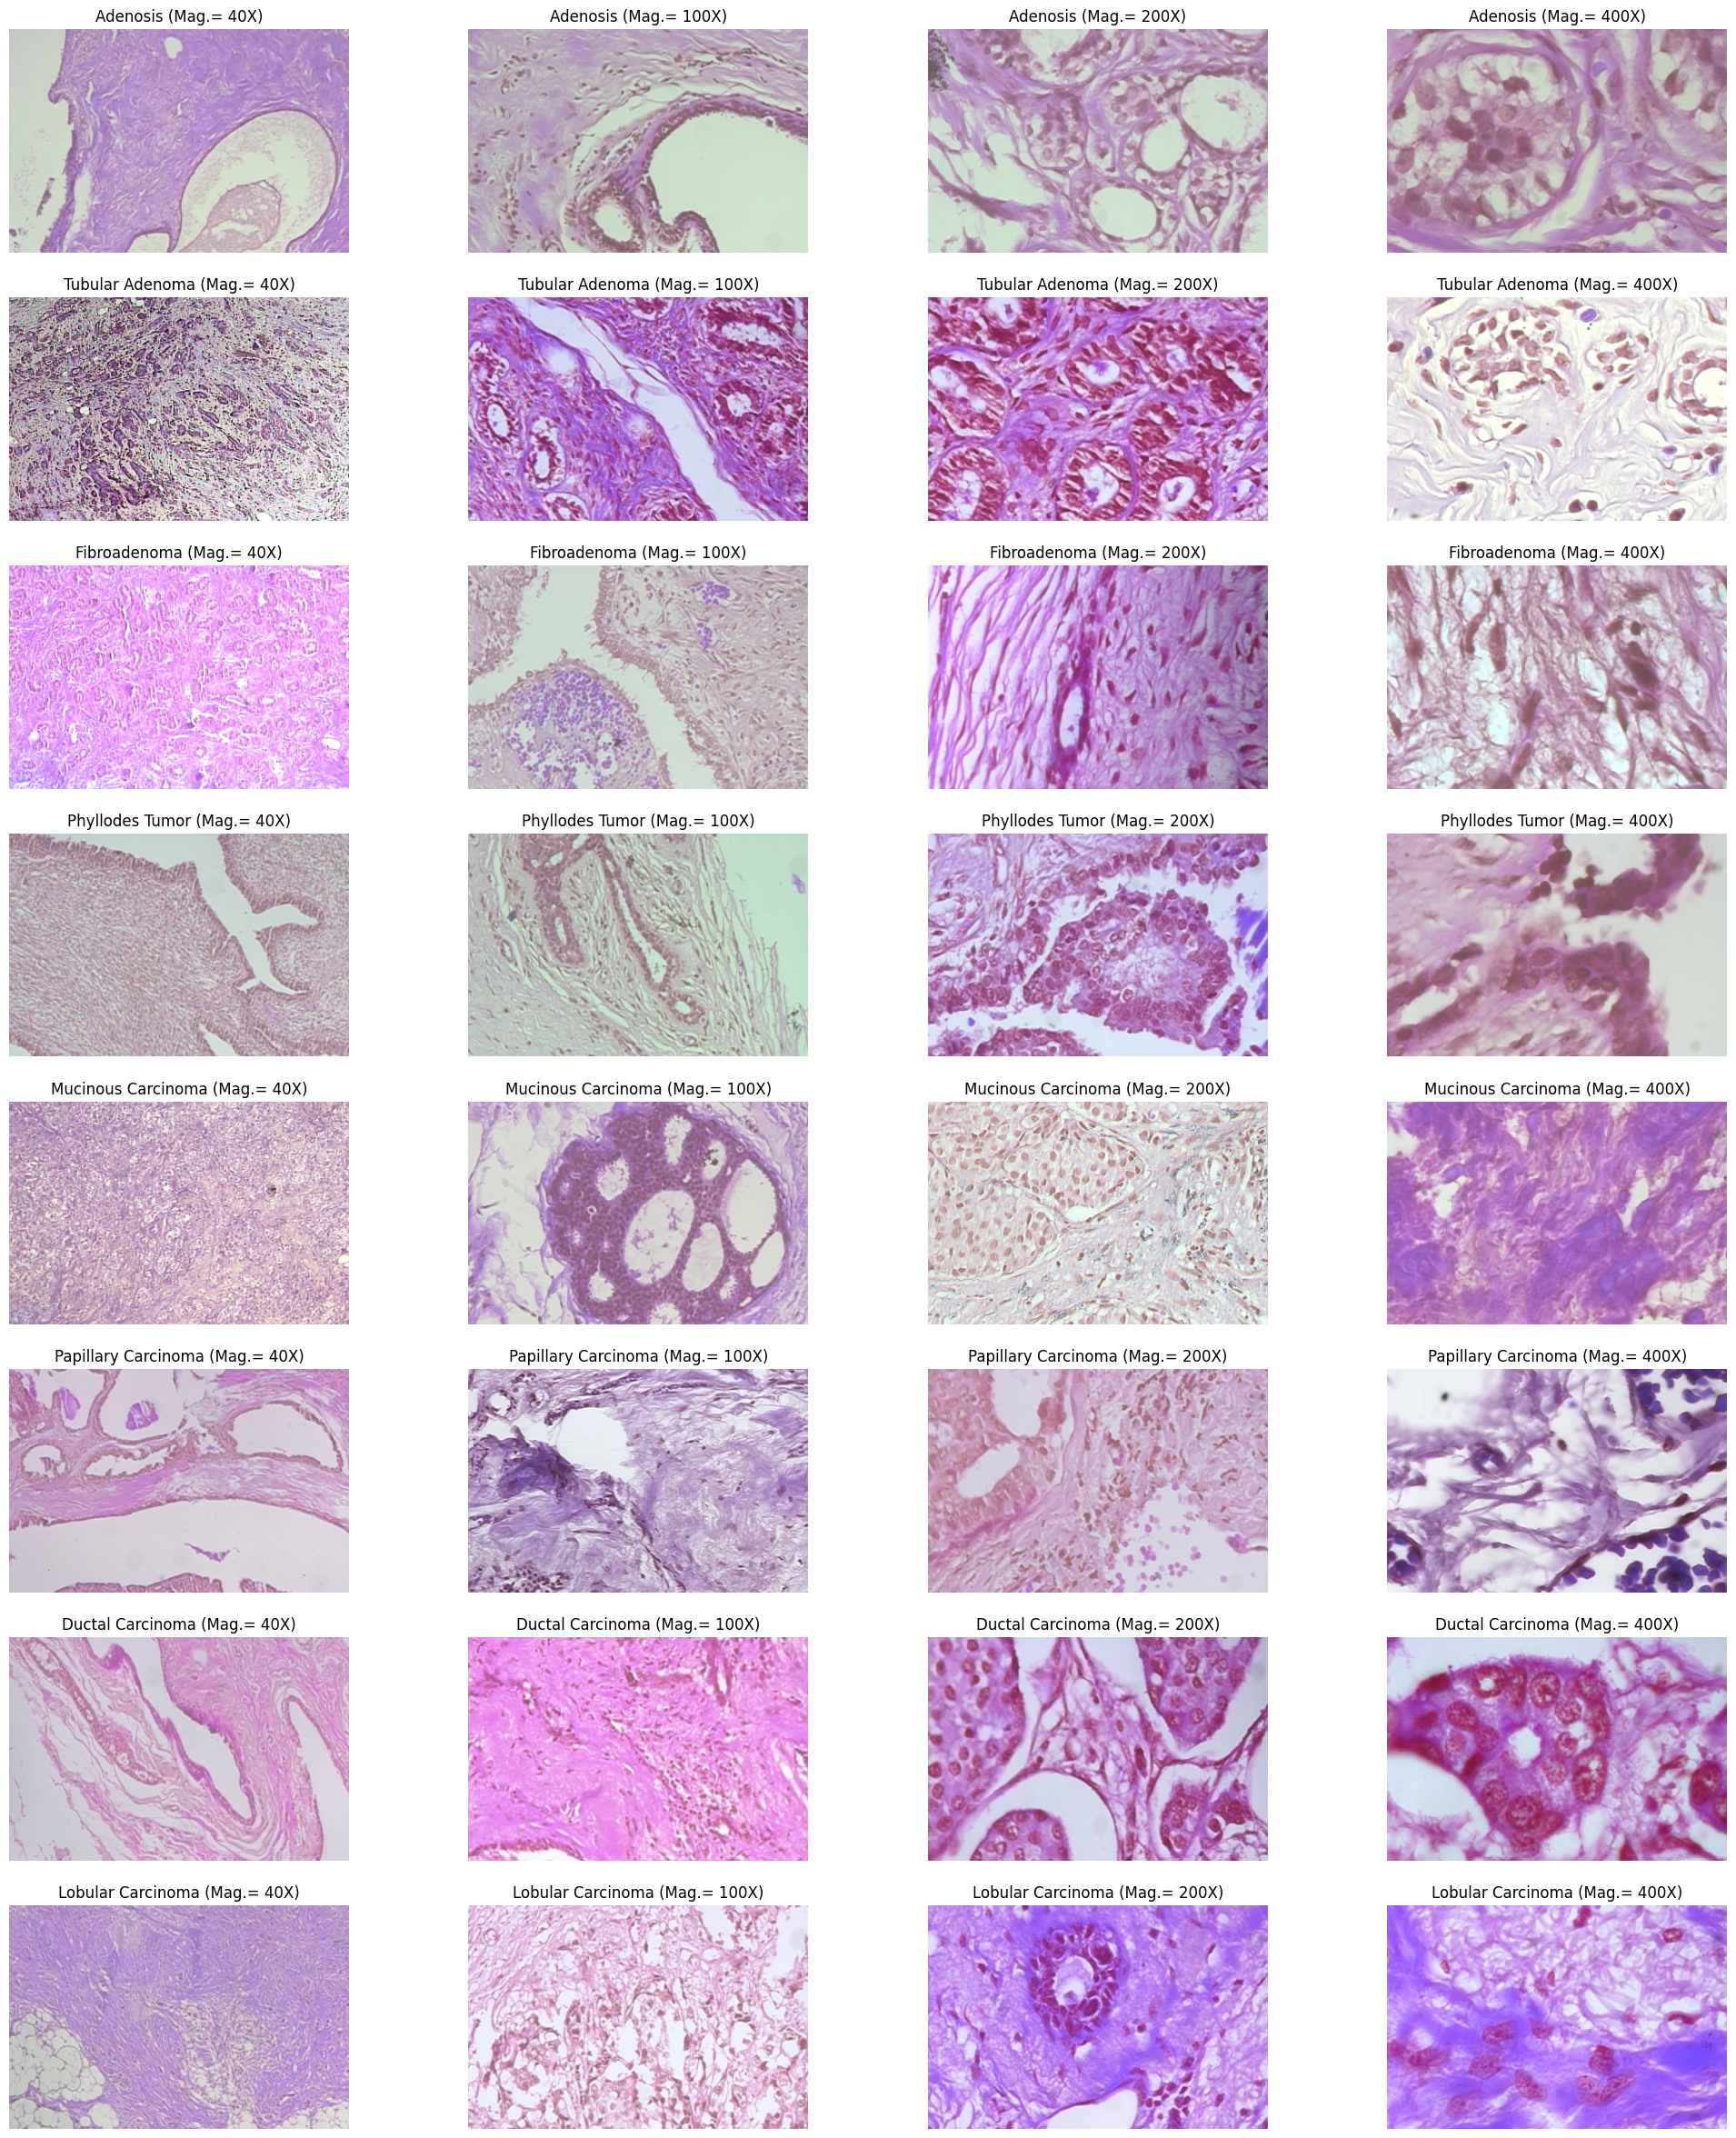

In [20]:
magnifications = ['40X', '100X', '200X', '400X']
cancer_types = list(img_metadata_df['Cancer Type'].unique())
            
plot_images_compare_magnification(img_metadata_df, cancer_types, magnifications)